We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.


Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Loading

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls "./gdrive/My Drive/Colab/kaggle/"

data.pkl		     lstm_1_0202_submission.csv
deep_lstm.csv		     lstm2_submission.csv
EDA.ipynb		     lstm_32_64_64_submission.csv
ensembling		     lstm_mean_cat_lgbm_submission.csv
holidays.csv		     lstm_mean_cat_submission.csv
item_categories.csv	     rub_to_usd.csv
items.csv		     sales_train_v2.csv
keras_submission.csv	     shops.csv
lgbm_2_submission.csv	     submission.csv
lgbm_submission.csv	     submissions
lstm_100_128_submission.csv  test.csv
lstm_100_32_submission.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv("./gdrive/My Drive/Colab/kaggle/sales_train_v2.csv")
print(df_train.shape)
df_train.head(10)

(2935849, 6)


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0

In [5]:
df_items = pd.read_csv("./gdrive/My Drive/Colab/kaggle/items.csv")

print("items ",df_items.shape)
df_categories = pd.read_csv("./gdrive/My Drive/Colab/kaggle/item_categories.csv")
print("items categories ",df_categories.shape)
df_shops = pd.read_csv("./gdrive/My Drive/Colab/kaggle/shops.csv")
print("shops ", df_shops.shape)

df_test = pd.read_csv("./gdrive/My Drive/Colab/kaggle/test.csv")
print("test", df_test.shape)
#df_test.head(10)
#df_shops.head(15)
#df_items.head(10)

items  (22170, 3)
items categories  (84, 2)
shops  (60, 6)
test (214200, 3)


In [7]:
good_sales = df_test.merge(df_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = df_test[df_test['ID'].isin(good_sales['ID'])]
no_data_items = df_test[~(df_test['item_id'].isin(df_train['item_id']))]

print('1. Good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(df_test)-len(no_data_items)-len(good_pairs))

1. Good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


# EDA

In [0]:
print('Duplicates:', len(df_train[df_train.duplicated()]))
df_train.drop_duplicates(keep=False,inplace=True) 
df_train.shape

Duplicates: 6


(2935837, 6)

In [0]:
print(df_train.info())
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935837 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB
None


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [0]:
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
df_train = df_train.sort_values('date')

In [0]:
print(df_train['date'].min())
print( df_train['date'].max())
df_train.head()

2013-01-01 00:00:00
2015-10-31 00:00:00


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
17280 2013-01-01               0       28     1470       599.0           5.0
49083 2013-01-01               0       18     6724       299.5          -1.0
18451 2013-01-01               0       28     2321       999.0           1.0
81870 2013-01-01               0       54     4602       299.0           1.0
81865 2013-01-01               0       54     4886       899.0           2.0

In [0]:
temp = df_train.groupby('date')['item_cnt_day'].sum().reset_index()
temp = temp.set_index('date')

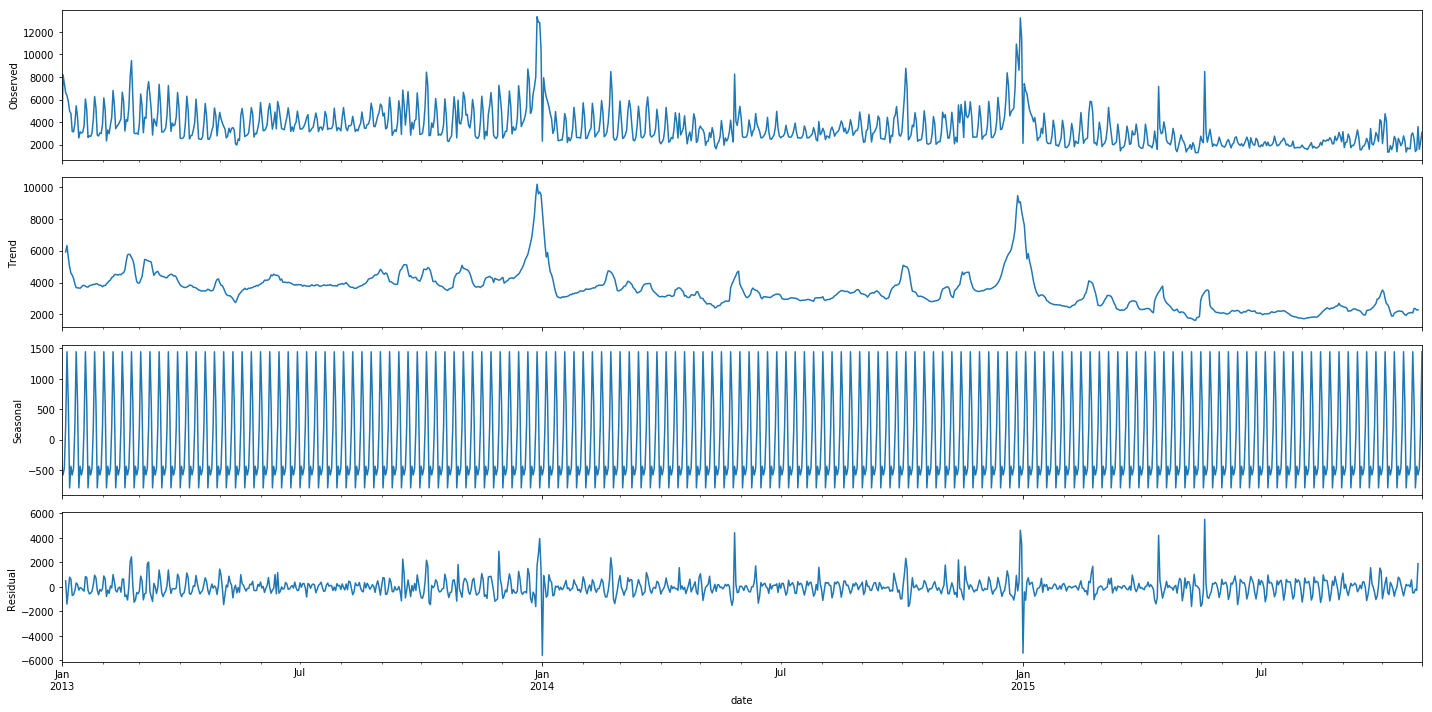

In [0]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(temp, model='additive')#, #freq=90)
fig = decomposition.plot()
plt.show()

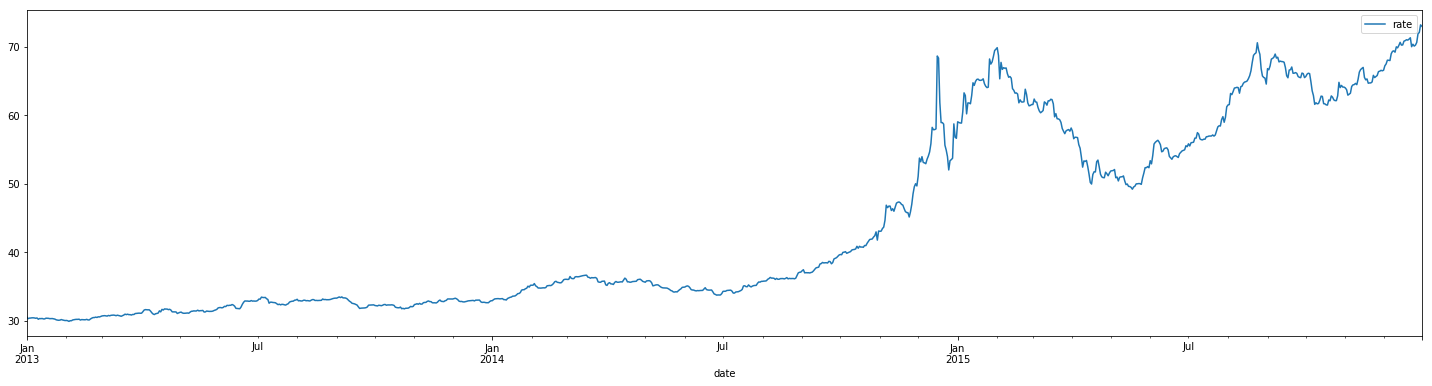

In [0]:
currency = pd.read_csv("./gdrive/My Drive/Colab/kaggle/rub_to_usd.csv", sep="\t", header=None, names=["date","rate"])
currency['date'] = pd.to_datetime(currency['date'], dayfirst=True)
currency = currency.sort_values('date')
currency = currency.set_index('date')
currency.plot(figsize=(25, 6))
plt.show()
#currency.head()

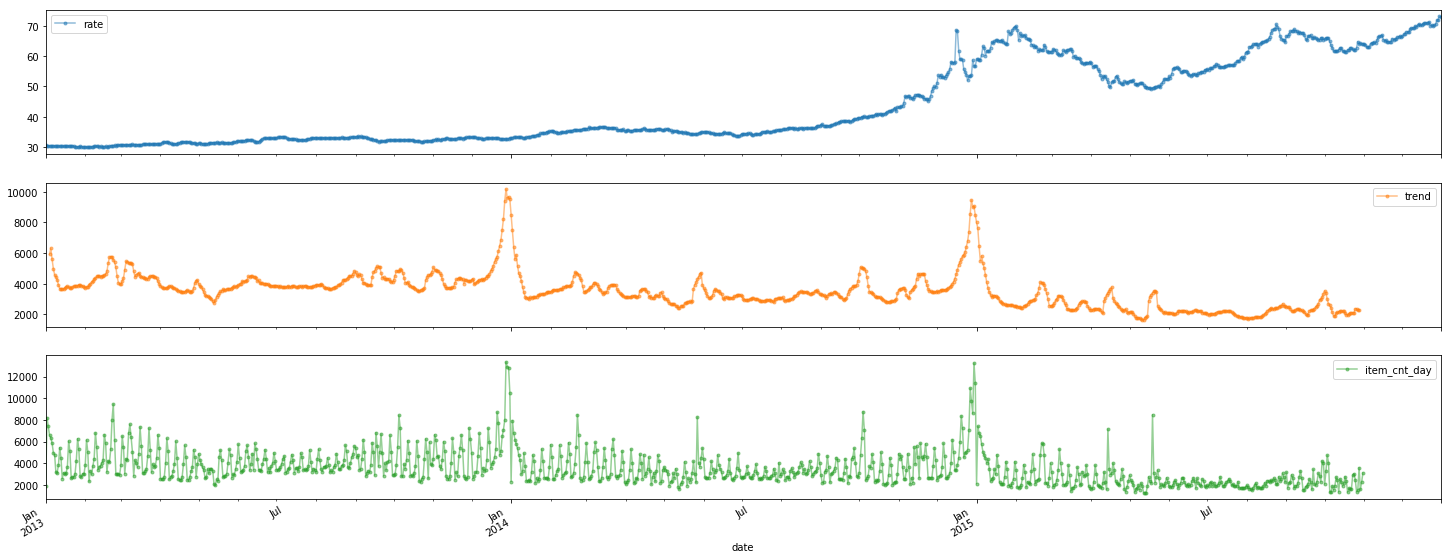

In [0]:
df2 = decomposition.trend
df2.columns = ["trend"]
macro = currency.join(temp, how='outer').join(df2, how='outer')
cols_plot = ['rate', 'trend','item_cnt_day']
axes = macro[cols_plot].plot(marker='.', alpha=0.5, figsize=(25, 10), subplots=True)

Cool, we will definitly add usd to rub rate to our data

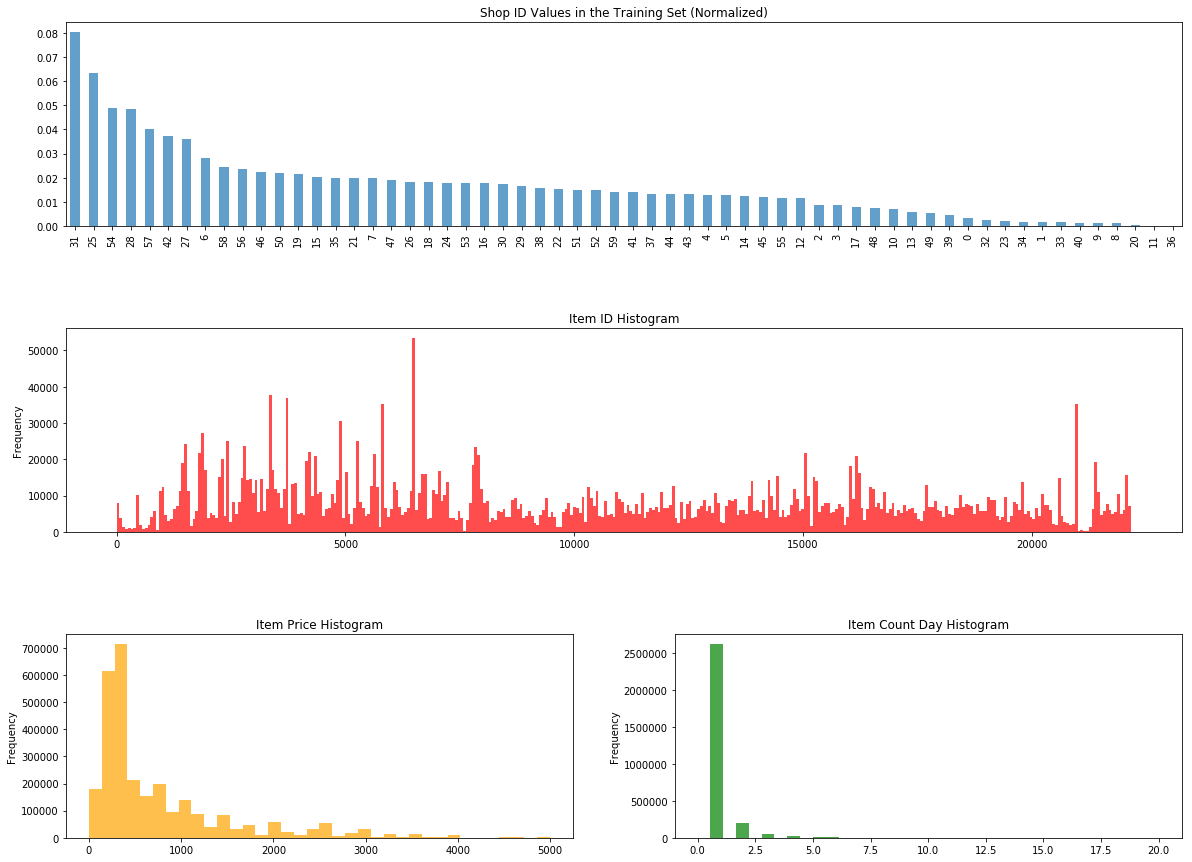

In [0]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2), (0,0), colspan = 2)
df_train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,2), (1,0), colspan = 2)
df_train['item_id'].plot(kind='hist', bins=360, alpha=0.7, color='red')
plt.title('Item ID Histogram')

plt.subplot2grid((3,2), (2,0))
df_train['item_price'].plot(kind='hist', bins=36, range=(0, 5000), alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,2), (2,1))
df_train['item_cnt_day'].plot(kind='hist', bins=36, range=(0, 20), alpha=0.7, color='green')
plt.title('Item Count Day Histogram')


plt.show()

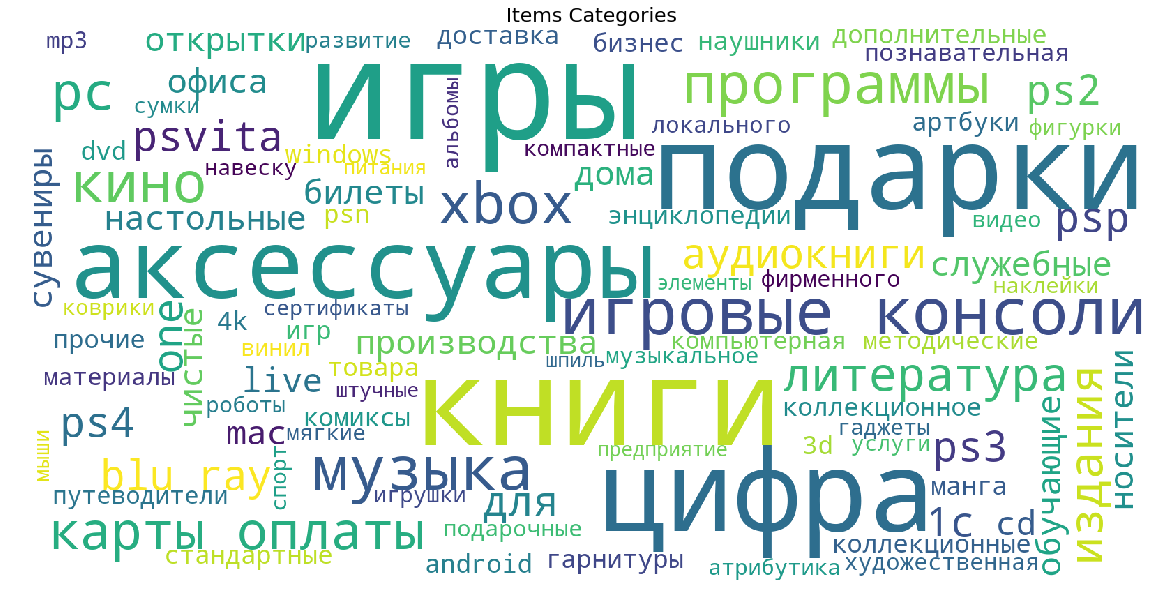

In [0]:
from wordcloud import WordCloud
import random


item_cat = ' '.join(df_categories.item_category_name).lower()
# wordcloud for display address
plt.figure(figsize=(20,20))
wc = WordCloud(background_color='white', max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=100,
                            relative_scaling=.5).generate(item_cat)
plt.imshow(wc)
#plt.imshow(wc)
plt.title("Items Categories", fontsize=20)
plt.savefig('items-cat-wordcloud.png')
plt.axis("off");

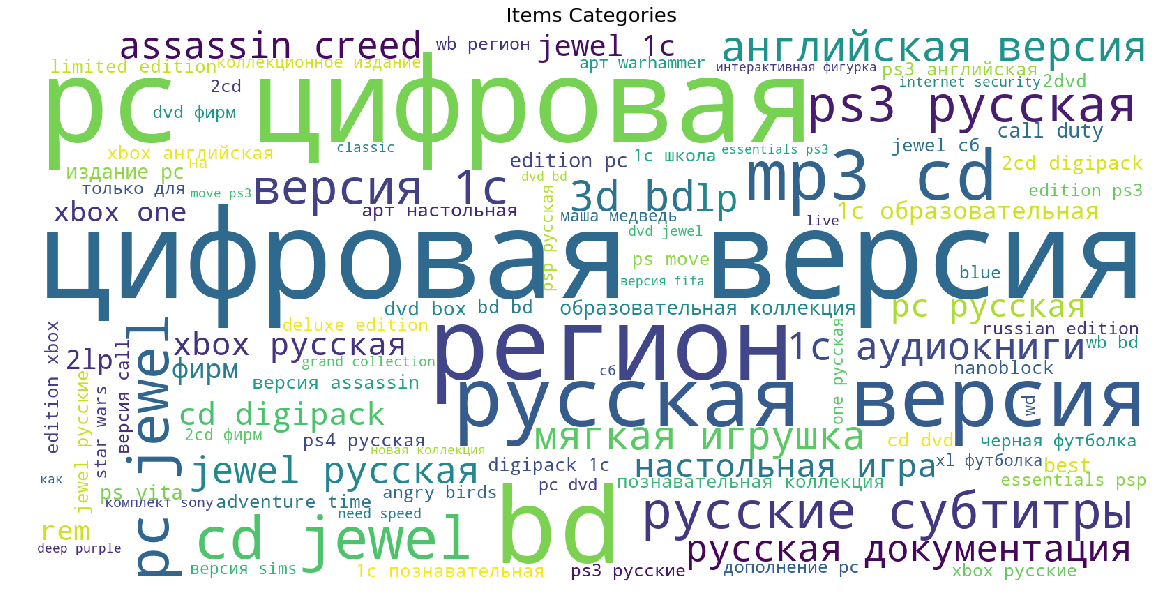

In [0]:
from wordcloud import WordCloud
import random


item_cat = ' '.join(df_items.item_name).lower()
# wordcloud for display address
plt.figure(figsize=(20,20))
wc = WordCloud(background_color='white', max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=100,
                            relative_scaling=.5).generate(item_cat)
plt.imshow(wc)
#plt.imshow(wc)
plt.title("Items Categories", fontsize=20)
plt.savefig('items-cat-wordcloud.png')
plt.axis("off");

In [0]:
def basic_eda(df):
    print("----------Head-----------------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Columns--------------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [0]:
#Litle bit of exploration of data

print("Sales")
basic_eda(df_train)

=============================     Sales    =============================
----------Head-----------------
            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
17280 2013-01-01               0       28     1470       599.0           5.0
49083 2013-01-01               0       18     6724       299.5          -1.0
18451 2013-01-01               0       28     2321       999.0           1.0
81870 2013-01-01               0       54     4602       299.0           1.0
81865 2013-01-01               0       54     4886       899.0           2.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935837 entries, 17280 to 2932751
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB
None
----------Columns--------------
date              da

In [0]:
print("Items")
basic_eda(df_items)


=============================     Items    =============================
----------Head-----------------
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
----------Columns--------------
item_name           object
item_id              int64
item_cat

In [0]:
print("Categories")
basic_eda(df_categories)


=============================   Categories  =============================
----------Head-----------------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
----------Columns--------------
item_category_name    object
item_category_id       int64
dtype: object
-------Missing Values----------
item_category_name    0
item_category_id      0
dtype: int64
-------NULL values-------------
item_category_name    0
item_category_id      0
dtype: int64
-----Shape Of Data-------------
(84, 2)


In [0]:
print("Shops")
basic_eda(df_shops)

=============================     Shops    =============================
----------Head-----------------
                        shop_name  shop_id  Unnamed: 2   2013   2014   2015
0   !Якутск Орджоникидзе, 56 фран        0         NaN  46542  51111  54631
1   !Якутск ТЦ "Центральный" фран        1         NaN  46542  51111  54631
2                Адыгея ТЦ "Мега"        2         NaN  19276  20945  22087
3  Балашиха ТРК "Октябрь-Киномир"        3         NaN  35690  38598  40643
4        Волжский ТЦ "Волга Молл"        4         NaN  21046  22828  24361
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
shop_name     60 non-null object
shop_id       60 non-null int64
Unnamed: 2    0 non-null float64
2013          60 non-null int64
2014          60 non-null int64
2015          60 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.9+ KB
None
----------Columns--------------
shop_name   